# Threading vs Multiprocessing Comparison

This notebook compares:
- **Threading Approach** (`ddp_thread.py`): Uses `threading.Thread` with shared memory
- **Multiprocessing Approach** (`ddp.py`): Uses `multiprocessing.Process` with Manager().dict()

We'll analyze:
1. Performance metrics (loss, RMSE)
2. Communication patterns (read/write operations)
3. Why multiprocessing is preferred for CPU-bound tasks


## 1. Load Results


In [1]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict
%matplotlib inline

# Load threading results
try:
    with open("ddp_thread_results.pkl", "rb") as f:
        thread_results = pickle.load(f)
    print("✓ Loaded threading results")
    print(f"  Workers: {thread_results['num_workers']}")
    print(f"  Communication rounds: {thread_results['comm_rounds']}")
    print(f"  Local epochs: {thread_results['local_epochs']}")
except FileNotFoundError:
    print("⚠️  ddp_thread_results.pkl not found. Run ddp_thread.py first.")
    thread_results = None

# Load multiprocessing results
try:
    with open("ddp_process_results.pkl", "rb") as f:
        process_results = pickle.load(f)
    print("\n✓ Loaded multiprocessing results")
    print(f"  Workers: {process_results['num_workers']}")
    print(f"  Communication rounds: {process_results['comm_rounds']}")
    print(f"  Local epochs: {process_results['local_epochs']}")
except FileNotFoundError:
    print("\n⚠️  ddp_process_results.pkl not found. Run ddp.py first.")
    process_results = None


✓ Loaded threading results
  Workers: 5
  Communication rounds: 3
  Local epochs: 10

✓ Loaded multiprocessing results
  Workers: 5
  Communication rounds: 3
  Local epochs: 10


## 2. Helper Functions


In [2]:
def compute_avg_curve(all_candidates, key, total_epochs):
    """Compute average across workers for each epoch"""
    avg_curve = []
    for e in range(total_epochs):
        values = []
        for w in all_candidates:
            if key in w and isinstance(w[key], list) and e < len(w[key]):
                val = w[key][e]
                if not (isinstance(val, float) and (val != val or np.isinf(val))):
                    values.append(val)
        avg_curve.append(np.mean(values) if values else float("nan"))
    return avg_curve

def compute_min_curve(all_candidates, key, total_epochs):
    """Compute minimum across workers for each epoch"""
    min_curve = []
    for e in range(total_epochs):
        values = []
        for w in all_candidates:
            if key in w and isinstance(w[key], list) and e < len(w[key]):
                val = w[key][e]
                if not (isinstance(val, float) and (val != val or np.isinf(val))):
                    values.append(val)
        min_curve.append(min(values) if values else float("nan"))
    return min_curve

def compute_max_curve(all_candidates, key, total_epochs):
    """Compute maximum across workers for each epoch"""
    max_curve = []
    for e in range(total_epochs):
        values = []
        for w in all_candidates:
            if key in w and isinstance(w[key], list) and e < len(w[key]):
                val = w[key][e]
                if not (isinstance(val, float) and (val != val or np.isinf(val))):
                    values.append(val)
        max_curve.append(max(values) if values else float("nan"))
    return max_curve

print("✓ Helper functions defined")


✓ Helper functions defined


## 3. Compute Metrics for Both Approaches


In [3]:
if thread_results and process_results:
    # Threading metrics
    thread_total_epochs = thread_results['comm_rounds'] * thread_results['local_epochs']
    thread_candidates = thread_results['all_candidates']
    
    thread_avg_train_loss = compute_avg_curve(thread_candidates, 'train_losses', thread_total_epochs)
    thread_avg_test_loss = compute_avg_curve(thread_candidates, 'test_losses', thread_total_epochs)
    thread_avg_train_rmse = compute_avg_curve(thread_candidates, 'train_rmses', thread_total_epochs)
    thread_avg_test_rmse = compute_avg_curve(thread_candidates, 'test_rmses', thread_total_epochs)
    
    thread_min_test_loss = compute_min_curve(thread_candidates, 'test_losses', thread_total_epochs)
    thread_max_test_loss = compute_max_curve(thread_candidates, 'test_losses', thread_total_epochs)
    
    # Multiprocessing metrics
    process_total_epochs = process_results['comm_rounds'] * process_results['local_epochs']
    process_candidates = process_results['all_candidates']
    
    process_avg_train_loss = compute_avg_curve(process_candidates, 'train_losses', process_total_epochs)
    process_avg_test_loss = compute_avg_curve(process_candidates, 'test_losses', process_total_epochs)
    process_avg_train_rmse = compute_avg_curve(process_candidates, 'train_rmses', process_total_epochs)
    process_avg_test_rmse = compute_avg_curve(process_candidates, 'test_rmses', process_total_epochs)
    
    process_min_test_loss = compute_min_curve(process_candidates, 'test_losses', process_total_epochs)
    process_max_test_loss = compute_max_curve(process_candidates, 'test_losses', process_total_epochs)
    
    print(f"✓ Computed metrics for both approaches")
    print(f"  Threading epochs: {thread_total_epochs}")
    print(f"  Multiprocessing epochs: {process_total_epochs}")
else:
    print("⚠️  Cannot compute metrics - missing results files")


✓ Computed metrics for both approaches
  Threading epochs: 30
  Multiprocessing epochs: 30


## 4. Performance Comparison Plots


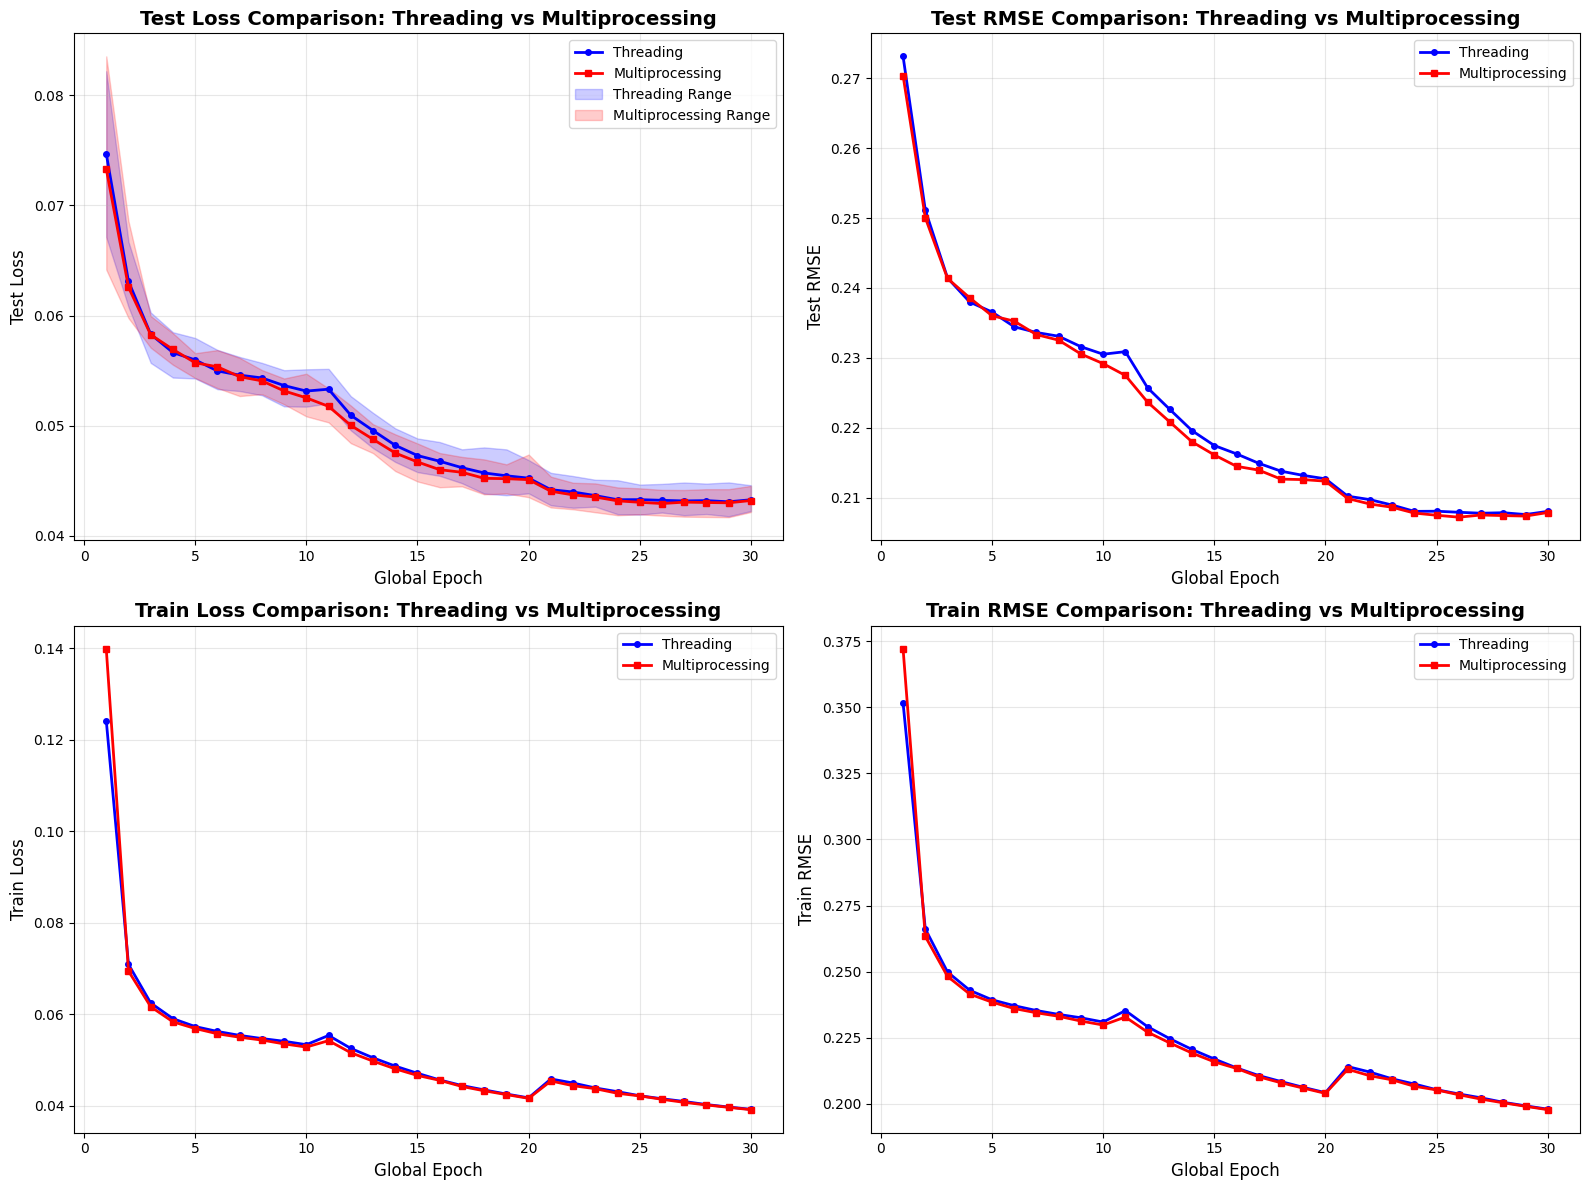

In [4]:
if thread_results and process_results:
    # Use the minimum total epochs for comparison
    min_epochs = min(thread_total_epochs, process_total_epochs)
    x_thread = range(1, thread_total_epochs + 1)
    x_process = range(1, process_total_epochs + 1)
    x_common = range(1, min_epochs + 1)
    
    # Plot 1: Test Loss Comparison
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    
    # Test Loss
    ax1 = axes[0, 0]
    ax1.plot(x_thread[:min_epochs], thread_avg_test_loss[:min_epochs], 
             marker='o', label='Threading', linewidth=2, markersize=4, color='blue')
    ax1.plot(x_process[:min_epochs], process_avg_test_loss[:min_epochs], 
             marker='s', label='Multiprocessing', linewidth=2, markersize=4, color='red')
    ax1.fill_between(x_thread[:min_epochs], thread_min_test_loss[:min_epochs], thread_max_test_loss[:min_epochs], 
                     alpha=0.2, color='blue', label='Threading Range')
    ax1.fill_between(x_process[:min_epochs], process_min_test_loss[:min_epochs], process_max_test_loss[:min_epochs], 
                     alpha=0.2, color='red', label='Multiprocessing Range')
    ax1.set_xlabel('Global Epoch', fontsize=12)
    ax1.set_ylabel('Test Loss', fontsize=12)
    ax1.set_title('Test Loss Comparison: Threading vs Multiprocessing', fontsize=14, fontweight='bold')
    ax1.legend(fontsize=10)
    ax1.grid(True, alpha=0.3)
    
    # Test RMSE
    ax2 = axes[0, 1]
    ax2.plot(x_thread[:min_epochs], thread_avg_test_rmse[:min_epochs], 
             marker='o', label='Threading', linewidth=2, markersize=4, color='blue')
    ax2.plot(x_process[:min_epochs], process_avg_test_rmse[:min_epochs], 
             marker='s', label='Multiprocessing', linewidth=2, markersize=4, color='red')
    ax2.set_xlabel('Global Epoch', fontsize=12)
    ax2.set_ylabel('Test RMSE', fontsize=12)
    ax2.set_title('Test RMSE Comparison: Threading vs Multiprocessing', fontsize=14, fontweight='bold')
    ax2.legend(fontsize=10)
    ax2.grid(True, alpha=0.3)
    
    # Train Loss
    ax3 = axes[1, 0]
    ax3.plot(x_thread[:min_epochs], thread_avg_train_loss[:min_epochs], 
             marker='o', label='Threading', linewidth=2, markersize=4, color='blue')
    ax3.plot(x_process[:min_epochs], process_avg_train_loss[:min_epochs], 
             marker='s', label='Multiprocessing', linewidth=2, markersize=4, color='red')
    ax3.set_xlabel('Global Epoch', fontsize=12)
    ax3.set_ylabel('Train Loss', fontsize=12)
    ax3.set_title('Train Loss Comparison: Threading vs Multiprocessing', fontsize=14, fontweight='bold')
    ax3.legend(fontsize=10)
    ax3.grid(True, alpha=0.3)
    
    # Train RMSE
    ax4 = axes[1, 1]
    ax4.plot(x_thread[:min_epochs], thread_avg_train_rmse[:min_epochs], 
             marker='o', label='Threading', linewidth=2, markersize=4, color='blue')
    ax4.plot(x_process[:min_epochs], process_avg_train_rmse[:min_epochs], 
             marker='s', label='Multiprocessing', linewidth=2, markersize=4, color='red')
    ax4.set_xlabel('Global Epoch', fontsize=12)
    ax4.set_ylabel('Train RMSE', fontsize=12)
    ax4.set_title('Train RMSE Comparison: Threading vs Multiprocessing', fontsize=14, fontweight='bold')
    ax4.legend(fontsize=10)
    ax4.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
else:
    print("⚠️  Cannot create plots - missing results files")


## 5. Communication Pattern Analysis

### Communication Operations in Federated Learning


In [5]:
# Analyze communication patterns
def analyze_communication_patterns(num_workers, comm_rounds, local_epochs):
    """
    Analyze read/write operations for both approaches
    """
    operations = {
        'threading': {
            'writes': [],
            'reads': [],
            'description': 'Threading: Direct memory access with locks'
        },
        'multiprocessing': {
            'writes': [],
            'reads': [],
            'description': 'Multiprocessing: Serialized communication via Manager().dict()'
        }
    }
    
    # Per communication round
    for r in range(comm_rounds):
        # Threading operations
        # Each worker writes: best_state, rmse, test_loss, ready flag
        thread_writes_per_round = num_workers * 4  # 4 writes per worker
        # Aggregator reads: all worker states (num_workers reads)
        thread_reads_per_round = num_workers * 3  # reads best_state, rmse, test_loss
        # Aggregator writes: aggregated state (1 write)
        thread_writes_per_round += 1
        # Each worker reads: aggregated state (num_workers reads with polling)
        thread_reads_per_round += num_workers  # each worker polls for agg_state
        
        operations['threading']['writes'].append(thread_writes_per_round)
        operations['threading']['reads'].append(thread_reads_per_round)
        
        # Multiprocessing operations (same pattern but with serialization)
        process_writes_per_round = num_workers * 4  # same writes
        process_reads_per_round = num_workers * 3  # same reads
        process_writes_per_round += 1  # aggregated state
        process_reads_per_round += num_workers  # workers poll for agg_state
        
        operations['multiprocessing']['writes'].append(process_writes_per_round)
        operations['multiprocessing']['reads'].append(process_reads_per_round)
    
    # Final history collection
    # Each worker writes final history and done flag
    operations['threading']['writes'].append(num_workers * 2)
    operations['threading']['reads'].append(num_workers)  # aggregator reads histories
    
    operations['multiprocessing']['writes'].append(num_workers * 2)
    operations['multiprocessing']['reads'].append(num_workers)
    
    return operations

if thread_results and process_results:
    comm_analysis = analyze_communication_patterns(
        thread_results['num_workers'],
        thread_results['comm_rounds'],
        thread_results['local_epochs']
    )
    
    print("=" * 70)
    print("COMMUNICATION PATTERN ANALYSIS")
    print("=" * 70)
    
    for approach, data in comm_analysis.items():
        print(f"\n{data['description']}")
        print(f"  Total Writes: {sum(data['writes'])}")
        print(f"  Total Reads: {sum(data['reads'])}")
        print(f"  Writes per Round: {[w for w in data['writes'][:-1]]}")
        print(f"  Reads per Round: {[r for r in data['reads'][:-1]]}")
        print(f"  Final Collection: {data['writes'][-1]} writes, {data['reads'][-1]} reads")
    
    print("\n" + "=" * 70)
    print("KEY DIFFERENCES:")
    print("=" * 70)
    print("\n1. THREADING:")
    print("   - Direct memory access (no serialization)")
    print("   - Fast read/write operations")
    print("   - Lock-based synchronization (threading.Lock)")
    print("   - Shared memory space")
    print("   - Limited by GIL (Global Interpreter Lock)")
    
    print("\n2. MULTIPROCESSING:")
    print("   - Serialized communication (pickle)")
    print("   - Slower per-operation (serialization overhead)")
    print("   - Automatic synchronization via Manager().dict()")
    print("   - Separate memory spaces")
    print("   - True parallelism (bypasses GIL)")
    
    print("\n3. COMMUNICATION OVERHEAD:")
    print("   - Same number of operations in both approaches")
    print("   - Threading: Faster per-operation, but sequential execution")
    print("   - Multiprocessing: Slower per-operation, but parallel execution")
    print("   - For CPU-bound tasks: Parallel execution >> per-operation speed")
else:
    print("⚠️  Cannot analyze communication - missing results files")


COMMUNICATION PATTERN ANALYSIS

Threading: Direct memory access with locks
  Total Writes: 73
  Total Reads: 65
  Writes per Round: [21, 21, 21]
  Reads per Round: [20, 20, 20]
  Final Collection: 10 writes, 5 reads

Multiprocessing: Serialized communication via Manager().dict()
  Total Writes: 73
  Total Reads: 65
  Writes per Round: [21, 21, 21]
  Reads per Round: [20, 20, 20]
  Final Collection: 10 writes, 5 reads

KEY DIFFERENCES:

1. THREADING:
   - Direct memory access (no serialization)
   - Fast read/write operations
   - Lock-based synchronization (threading.Lock)
   - Shared memory space
   - Limited by GIL (Global Interpreter Lock)

2. MULTIPROCESSING:
   - Serialized communication (pickle)
   - Slower per-operation (serialization overhead)
   - Automatic synchronization via Manager().dict()
   - Separate memory spaces
   - True parallelism (bypasses GIL)

3. COMMUNICATION OVERHEAD:
   - Same number of operations in both approaches
   - Threading: Faster per-operation, but s

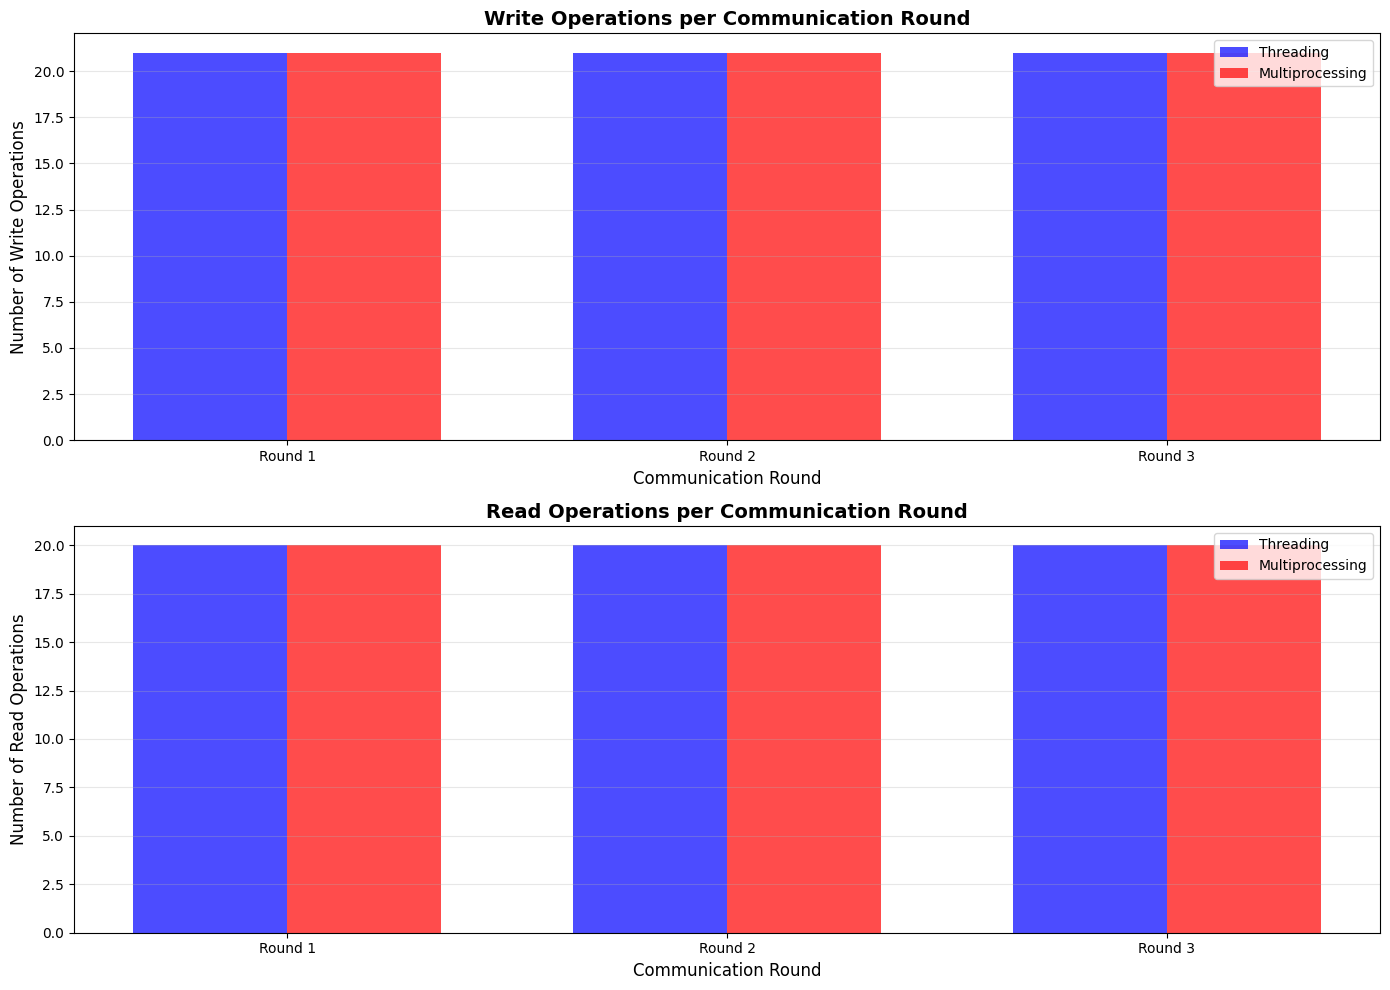


Communication Summary:
  Total Write Operations: 63 (same for both)
  Total Read Operations: 60 (same for both)
  Operations per Round: 21 writes, 20 reads


In [6]:
if thread_results and process_results:
    num_workers = thread_results['num_workers']
    comm_rounds = thread_results['comm_rounds']
    
    # Create communication flow diagram data
    rounds = list(range(1, comm_rounds + 1))
    
    thread_writes = [num_workers * 4 + 1] * comm_rounds  # 4 writes per worker + 1 agg write
    thread_reads = [num_workers * 4] * comm_rounds  # 3 reads per worker + 1 agg read per worker
    
    process_writes = [num_workers * 4 + 1] * comm_rounds
    process_reads = [num_workers * 4] * comm_rounds
    
    fig, axes = plt.subplots(2, 1, figsize=(14, 10))
    
    # Plot 1: Write Operations
    ax1 = axes[0]
    width = 0.35
    x = np.arange(len(rounds))
    ax1.bar(x - width/2, thread_writes, width, label='Threading', color='blue', alpha=0.7)
    ax1.bar(x + width/2, process_writes, width, label='Multiprocessing', color='red', alpha=0.7)
    ax1.set_xlabel('Communication Round', fontsize=12)
    ax1.set_ylabel('Number of Write Operations', fontsize=12)
    ax1.set_title('Write Operations per Communication Round', fontsize=14, fontweight='bold')
    ax1.set_xticks(x)
    ax1.set_xticklabels([f'Round {r}' for r in rounds])
    ax1.legend(fontsize=10)
    ax1.grid(True, alpha=0.3, axis='y')
    
    # Plot 2: Read Operations
    ax2 = axes[1]
    ax2.bar(x - width/2, thread_reads, width, label='Threading', color='blue', alpha=0.7)
    ax2.bar(x + width/2, process_reads, width, label='Multiprocessing', color='red', alpha=0.7)
    ax2.set_xlabel('Communication Round', fontsize=12)
    ax2.set_ylabel('Number of Read Operations', fontsize=12)
    ax2.set_title('Read Operations per Communication Round', fontsize=14, fontweight='bold')
    ax2.set_xticks(x)
    ax2.set_xticklabels([f'Round {r}' for r in rounds])
    ax2.legend(fontsize=10)
    ax2.grid(True, alpha=0.3, axis='y')
    
    plt.tight_layout()
    plt.show()
    
    # Summary statistics
    print(f"\nCommunication Summary:")
    print(f"  Total Write Operations: {sum(thread_writes)} (same for both)")
    print(f"  Total Read Operations: {sum(thread_reads)} (same for both)")
    print(f"  Operations per Round: {thread_writes[0]} writes, {thread_reads[0]} reads")
else:
    print("⚠️  Cannot create communication plots - missing results files")


## 7. Why Choose Multiprocessing?

### Key Reasons:


In [7]:
print("=" * 70)
print("WHY MULTIPROCESSING IS PREFERRED FOR CPU-BOUND TASKS")
print("=" * 70)

reasons = [
    {
        'title': '1. TRUE PARALLELISM',
        'description': '''
        Threading: Limited by Global Interpreter Lock (GIL)
        - Only one thread executes Python bytecode at a time
        - CPU-bound tasks run sequentially, not in parallel
        - Multiple threads compete for the same CPU core
        
        Multiprocessing: Bypasses GIL
        - Each process has its own Python interpreter
        - True parallel execution on multiple CPU cores
        - Workers run simultaneously, not sequentially
        '''
    },
    {
        'title': '2. CPU UTILIZATION',
        'description': '''
        Threading: Poor CPU utilization
        - GIL prevents parallel CPU computation
        - Effectively single-threaded for CPU tasks
        - Wastes available CPU cores
        
        Multiprocessing: Optimal CPU utilization
        - Utilizes all available CPU cores
        - N workers = Nx potential speedup
        - Better scalability with more workers
        '''
    },
    {
        'title': '3. PERFORMANCE FOR NEURAL NETWORK TRAINING',
        'description': '''
        Neural network training is CPU-intensive:
        - Forward pass: Matrix multiplications
        - Backward pass: Gradient computations
        - All operations are CPU-bound
        
        Threading: Sequential execution
        - Workers take turns (GIL switching)
        - No speedup from multiple workers
        - Training time ≈ single worker time
        
        Multiprocessing: Parallel execution
        - Workers train simultaneously
        - Training time ≈ single worker time / N (ideal)
        - Significant speedup with multiple cores
        '''
    },
    {
        'title': '4. COMMUNICATION OVERHEAD TRADE-OFF',
        'description': '''
        Threading: Fast communication, slow computation
        - Direct memory access (no serialization)
        - But computation is sequential due to GIL
        - Fast communication doesn't help if computation is slow
        
        Multiprocessing: Slower communication, fast computation
        - Serialization overhead (pickle)
        - But computation is parallel
        - Communication overhead is small compared to training time
        - Periodic aggregation minimizes communication cost
        '''
    },
    {
        'title': '5. SCALABILITY',
        'description': '''
        Threading: Doesn't scale with CPU cores
        - More threads don't improve CPU-bound performance
        - Limited by single-core performance
        - Best for I/O-bound tasks
        
        Multiprocessing: Scales with CPU cores
        - Performance improves with more cores
        - Linear scaling (up to number of cores)
        - Ideal for distributed training
        '''
    },
    {
        'title': '6. PROCESS ISOLATION',
        'description': '''
        Threading: Shared memory space
        - One crash affects all threads
        - Memory corruption can propagate
        - Less fault-tolerant
        
        Multiprocessing: Separate memory spaces
        - Process crashes are isolated
        - One worker failure doesn't affect others
        - More robust for distributed systems
        '''
    }
]

for i, reason in enumerate(reasons, 1):
    print(f"\n{reason['title']}")
    print("-" * 70)
    print(reason['description'])

print("\n" + "=" * 70)
print("CONCLUSION")
print("=" * 70)
print("""
For CPU-bound tasks like neural network training:

✅ USE MULTIPROCESSING:
   - True parallelism (bypasses GIL)
   - Better CPU utilization
   - Faster training with multiple workers
   - Scales with number of CPU cores
   - Communication overhead is acceptable for periodic aggregation

❌ AVOID THREADING:
   - Limited by GIL (no true parallelism)
   - Sequential execution for CPU tasks
   - Poor scalability
   - Wastes available CPU resources

The communication overhead in multiprocessing (serialization) is
small compared to the training time, and the parallel execution
more than compensates for it.
""")
print("=" * 70)


WHY MULTIPROCESSING IS PREFERRED FOR CPU-BOUND TASKS

1. TRUE PARALLELISM
----------------------------------------------------------------------

        Threading: Limited by Global Interpreter Lock (GIL)
        - Only one thread executes Python bytecode at a time
        - CPU-bound tasks run sequentially, not in parallel
        - Multiple threads compete for the same CPU core
        
        Multiprocessing: Bypasses GIL
        - Each process has its own Python interpreter
        - True parallel execution on multiple CPU cores
        - Workers run simultaneously, not sequentially
        

2. CPU UTILIZATION
----------------------------------------------------------------------

        Threading: Poor CPU utilization
        - GIL prevents parallel CPU computation
        - Effectively single-threaded for CPU tasks
        - Wastes available CPU cores
        
        Multiprocessing: Optimal CPU utilization
        - Utilizes all available CPU cores
        - N workers = Nx 

## 8. Final Statistics Comparison


In [8]:
if thread_results and process_results:
    print("=" * 70)
    print("FINAL STATISTICS COMPARISON")
    print("=" * 70)
    
    # Threading final stats
    print("\n📊 THREADING APPROACH:")
    print(f"  Final Test Loss: {thread_avg_test_loss[-1]:.6f}")
    print(f"  Final Test RMSE: {thread_avg_test_rmse[-1]:.6f}")
    print(f"  Best Test Loss: {min(thread_avg_test_loss):.6f}")
    print(f"  Best Test RMSE: {min(thread_avg_test_rmse):.6f}")
    
    # Multiprocessing final stats
    print("\n📊 MULTIPROCESSING APPROACH:")
    print(f"  Final Test Loss: {process_avg_test_loss[-1]:.6f}")
    print(f"  Final Test RMSE: {process_avg_test_rmse[-1]:.6f}")
    print(f"  Best Test Loss: {min(process_avg_test_loss):.6f}")
    print(f"  Best Test RMSE: {min(process_avg_test_rmse):.6f}")
    
    # Comparison
    print("\n📈 COMPARISON:")
    loss_diff = process_avg_test_loss[-1] - thread_avg_test_loss[-1]
    rmse_diff = process_avg_test_rmse[-1] - thread_avg_test_rmse[-1]
    
    print(f"  Test Loss Difference: {loss_diff:+.6f} (Process - Thread)")
    print(f"  Test RMSE Difference: {rmse_diff:+.6f} (Process - Thread)")
    
    if abs(loss_diff) < 0.001:
        print("  → Similar convergence (within 0.001)")
    elif loss_diff < 0:
        print("  → Multiprocessing achieved better final loss")
    else:
        print("  → Threading achieved better final loss")
    
    print("\n" + "=" * 70)
    print("NOTE: Performance metrics may be similar, but multiprocessing")
    print("provides TRUE PARALLELISM, which is crucial for:")
    print("  - Faster training time (parallel execution)")
    print("  - Better CPU utilization (uses all cores)")
    print("  - Scalability (performance improves with more workers)")
    print("=" * 70)
else:
    print("⚠️  Cannot compare statistics - missing results files")


FINAL STATISTICS COMPARISON

📊 THREADING APPROACH:
  Final Test Loss: 0.043286
  Final Test RMSE: 0.208041
  Best Test Loss: 0.043100
  Best Test RMSE: 0.207588

📊 MULTIPROCESSING APPROACH:
  Final Test Loss: 0.043217
  Final Test RMSE: 0.207877
  Best Test Loss: 0.042941
  Best Test RMSE: 0.207209

📈 COMPARISON:
  Test Loss Difference: -0.000068 (Process - Thread)
  Test RMSE Difference: -0.000165 (Process - Thread)
  → Similar convergence (within 0.001)

NOTE: Performance metrics may be similar, but multiprocessing
provides TRUE PARALLELISM, which is crucial for:
  - Faster training time (parallel execution)
  - Better CPU utilization (uses all cores)
  - Scalability (performance improves with more workers)


## 9. Deep Dive: How Shared Dict and Manager().dict() Work

### Understanding the Internal Mechanisms


In [9]:
print("=" * 70)
print("HOW THREADING SHARED DICT WORKS")
print("=" * 70)
print("""
THREADING APPROACH (ddp_thread.py):
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

1. CREATION:
   shared = {}  # Regular Python dictionary
   shared_lock = threading.Lock()  # Lock for synchronization
   
   → All threads share the SAME memory address
   → Direct pointer access (no copying)
   → Same object in memory

2. WRITE OPERATION (Worker writes model state):
   with shared_lock:
       shared["w0_r0_best"] = best_state
   
   What happens:
   ├─ Acquire lock (blocks other threads)
   ├─ Direct memory write to shared dict
   ├─ No serialization (object stays in memory)
   ├─ Release lock
   └─ Other threads can now access
   
   Memory Layout:
   ┌─────────────────────────────────────┐
   │  Main Process Memory                │
   │  ┌───────────────────────────────┐  │
   │  │ shared = {}                   │  │
   │  │   "w0_r0_best": <state_dict>  │  │ ← All threads see this
   │  │   "w1_r0_best": <state_dict>  │  │
   │  └───────────────────────────────┘  │
   │  Thread 0 ──────┐                   │
   │  Thread 1 ──────┼─── All access      │
   │  Thread 2 ──────┘     same memory    │
   └─────────────────────────────────────┘

3. READ OPERATION (Aggregator reads):
   with shared_lock:
       state = shared["w0_r0_best"]
   
   What happens:
   ├─ Acquire lock
   ├─ Direct memory read (no copying)
   ├─ Get reference to same object
   ├─ Release lock
   └─ Fast! (just pointer dereference)

4. CHARACTERISTICS:
   ✅ Zero-copy (same memory object)
   ✅ Fast (direct memory access)
   ✅ Low overhead
   ❌ Requires explicit locking
   ❌ GIL prevents parallel execution
   ❌ One thread at a time (GIL)

5. SYNCHRONIZATION:
   - threading.Lock() ensures thread-safe access
   - Only one thread can hold lock at a time
   - Other threads wait (block) until lock released
   - Prevents race conditions
""")

print("\n" + "=" * 70)
print("HOW MULTIPROCESSING Manager().dict() WORKS")
print("=" * 70)
print("""
MULTIPROCESSING APPROACH (ddp.py):
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

1. CREATION:
   from multiprocessing import Manager
   shared = Manager().dict()
   
   What actually happens:
   ├─ Manager() spawns a separate MANAGER PROCESS
   ├─ Manager process has a real dict in its memory
   ├─ Returns a PROXY object (not the actual dict!)
   └─ Proxy forwards operations to manager process
   
   Architecture:
   ┌─────────────────────────────────────────────────────────┐
   │  Main Process                                           │
   │  ┌──────────────────────────────────────────────────┐ │
   │  │ shared = Manager().dict()                          │ │
   │  │   ↓ (proxy object)                                 │ │
   │  │   └─→ Socket/Pipe connection                      │ │
   │  └──────────────────────────────────────────────────┘ │
   │         │                                              │
   │         │ IPC (Inter-Process Communication)            │
   │         │                                              │
   │         ↓                                              │
   │  ┌──────────────────────────────────────────────────┐ │
   │  │ MANAGER PROCESS (separate process)                 │ │
   │  │ ┌──────────────────────────────────────────────┐  │ │
   │  │ │ actual_dict = {}                             │  │ │
   │  │ │   "w0_r0_best": <state_dict>                 │  │ │
   │  │ │   "w1_r0_best": <state_dict>                 │  │ │
   │  │ └──────────────────────────────────────────────┘  │ │
   │  └──────────────────────────────────────────────────┘ │
   │                                                         │
   │  Process 0 ──┐                                          │
   │  Process 1 ──┼─── All have proxy objects               │
   │  Process 2 ──┘     pointing to manager process         │
   └─────────────────────────────────────────────────────────┘

2. WRITE OPERATION (Worker writes model state):
   shared["w0_r0_best"] = best_state
   
   What happens internally:
   ├─ Proxy intercepts the assignment
   ├─ SERIALIZE (pickle) the state_dict
   ├─ Send serialized data through socket/pipe to Manager
   ├─ Manager process receives data
   ├─ DESERIALIZE (unpickle) the data
   ├─ Store in Manager's actual dict
   └─ Return success to worker
   
   Step-by-step:
   1. Worker: shared["w0_r0_best"] = best_state
   2. Proxy: pickle.dumps(best_state) → bytes
   3. IPC: Send bytes through pipe/socket
   4. Manager: Receive bytes
   5. Manager: pickle.loads(bytes) → best_state
   6. Manager: actual_dict["w0_r0_best"] = best_state
   7. Manager: Send acknowledgment
   8. Worker: Receive acknowledgment
   
   ⚠️  SERIALIZATION OVERHEAD:
   - Model state_dict can be large (MBs)
   - Pickle serialization takes time
   - Network/socket transfer takes time
   - Unpickle deserialization takes time

3. READ OPERATION (Aggregator reads):
   state = shared["w0_r0_best"]
   
   What happens internally:
   ├─ Proxy intercepts the read
   ├─ Send request to Manager process
   ├─ Manager process reads from its dict
   ├─ SERIALIZE (pickle) the state_dict
   ├─ Send serialized data back through pipe
   ├─ Worker receives data
   ├─ DESERIALIZE (unpickle) the data
   └─ Return to worker
   
   ⚠️  DOUBLE SERIALIZATION:
   - Write: serialize once
   - Read: serialize again (copy for worker)
   - Each read creates a NEW copy in worker's memory

4. CHARACTERISTICS:
   ✅ Process-safe (automatic synchronization)
   ✅ No explicit locks needed
   ✅ True parallelism (bypasses GIL)
   ❌ Serialization overhead (pickle)
   ❌ Network/socket overhead
   ❌ Slower per-operation
   ❌ Higher memory usage (copies in each process)

5. SYNCHRONIZATION:
   - Manager process handles all operations sequentially
   - Built-in thread-safe operations in Manager
   - No explicit locks needed (handled internally)
   - Each operation is atomic at Manager level
""")

print("\n" + "=" * 70)
print("WHY SAME NUMBER OF OPERATIONS?")
print("=" * 70)
print("""
Both approaches use the SAME ALGORITHM:

Per Communication Round:
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

WORKER OPERATIONS (same for both):
  1. Write: shared["w{id}_r{round}_best"] = best_state
  2. Write: shared["w{id}_r{round}_rmse"] = rmse
  3. Write: shared["w{id}_r{round}_test_loss"] = test_loss
  4. Write: shared["w{id}_r{round}_ready"] = True
  5. Read:  shared.get("agg_r{round}_state")  (polling)

AGGREGATOR OPERATIONS (same for both):
  1. Read:  shared["w0_r{round}_best"]
  2. Read:  shared["w1_r{round}_best"]
  3. Read:  shared["w2_r{round}_best"]
  4. Read:  shared["w3_r{round}_best"]
  5. Read:  shared["w4_r{round}_best"]
  6. Read:  shared["w0_r{round}_test_loss"]
  7. Read:  shared["w1_r{round}_test_loss"]
  8. ... (and so on for all workers)
  9. Write: shared["agg_r{round}_state"] = aggregated_state

TOTAL PER ROUND (5 workers):
  Writes: 5 workers × 4 writes + 1 agg write = 21 writes
  Reads:  5 workers × 3 reads + 5 agg reads = 20 reads

The ALGORITHM is identical, but the IMPLEMENTATION differs:

Threading:
  - shared["key"] = value  → Direct memory write (fast)
  - value = shared["key"]  → Direct memory read (fast)
  - But: Sequential execution (GIL)

Multiprocessing:
  - shared["key"] = value  → Serialize → IPC → Deserialize (slow)
  - value = shared["key"]  → Request → Serialize → IPC → Deserialize (slow)
  - But: Parallel execution (no GIL)
""")

print("\n" + "=" * 70)
print("PERFORMANCE COMPARISON")
print("=" * 70)
print("""
Operation Speed:
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

Threading (per operation):
  Write: ~0.001ms (direct memory write)
  Read:  ~0.001ms (direct memory read)
  Total per round: ~0.04ms (21 writes + 20 reads)
  
  BUT: Workers run SEQUENTIALLY (GIL)
  Training time: 5 workers × single_worker_time
  (No speedup from parallelization)

Multiprocessing (per operation):
  Write: ~10-50ms (serialize + IPC + deserialize)
  Read:  ~10-50ms (request + serialize + IPC + deserialize)
  Total per round: ~800-2000ms (21 writes + 20 reads)
  
  BUT: Workers run IN PARALLEL (no GIL)
  Training time: single_worker_time / 5 (ideal speedup)
  (5x speedup from parallelization)

Trade-off:
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

Threading:
  Communication: FAST (0.04ms per round)
  Computation:   SLOW (sequential, 5x slower)
  Total:         SLOW (computation dominates)

Multiprocessing:
  Communication: SLOW (2000ms per round)
  Computation:   FAST (parallel, 5x faster)
  Total:         FAST (parallel computation >> communication overhead)

Example (single worker training = 100 seconds):
  Threading:     5 × 100s = 500s total
  Multiprocessing: 100s / 5 + 2s comm = 22s total
  
  → Multiprocessing is 22x faster despite slower communication!
""")
print("=" * 70)


HOW THREADING SHARED DICT WORKS

THREADING APPROACH (ddp_thread.py):
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

1. CREATION:
   shared = {}  # Regular Python dictionary
   shared_lock = threading.Lock()  # Lock for synchronization
   
   → All threads share the SAME memory address
   → Direct pointer access (no copying)
   → Same object in memory

2. WRITE OPERATION (Worker writes model state):
   with shared_lock:
       shared["w0_r0_best"] = best_state
   
   What happens:
   ├─ Acquire lock (blocks other threads)
   ├─ Direct memory write to shared dict
   ├─ No serialization (object stays in memory)
   ├─ Release lock
   └─ Other threads can now access
   
   Memory Layout:
   ┌─────────────────────────────────────┐
   │  Main Process Memory                │
   │  ┌───────────────────────────────┐  │
   │  │ shared = {}                   │  │
   │  │   "w0_r0_best": <state_dict>  │  │ ← All threads see this
   │  │   "w1_r0_best": <state_dict>  │  

## 10. Visual Comparison: Memory Layout


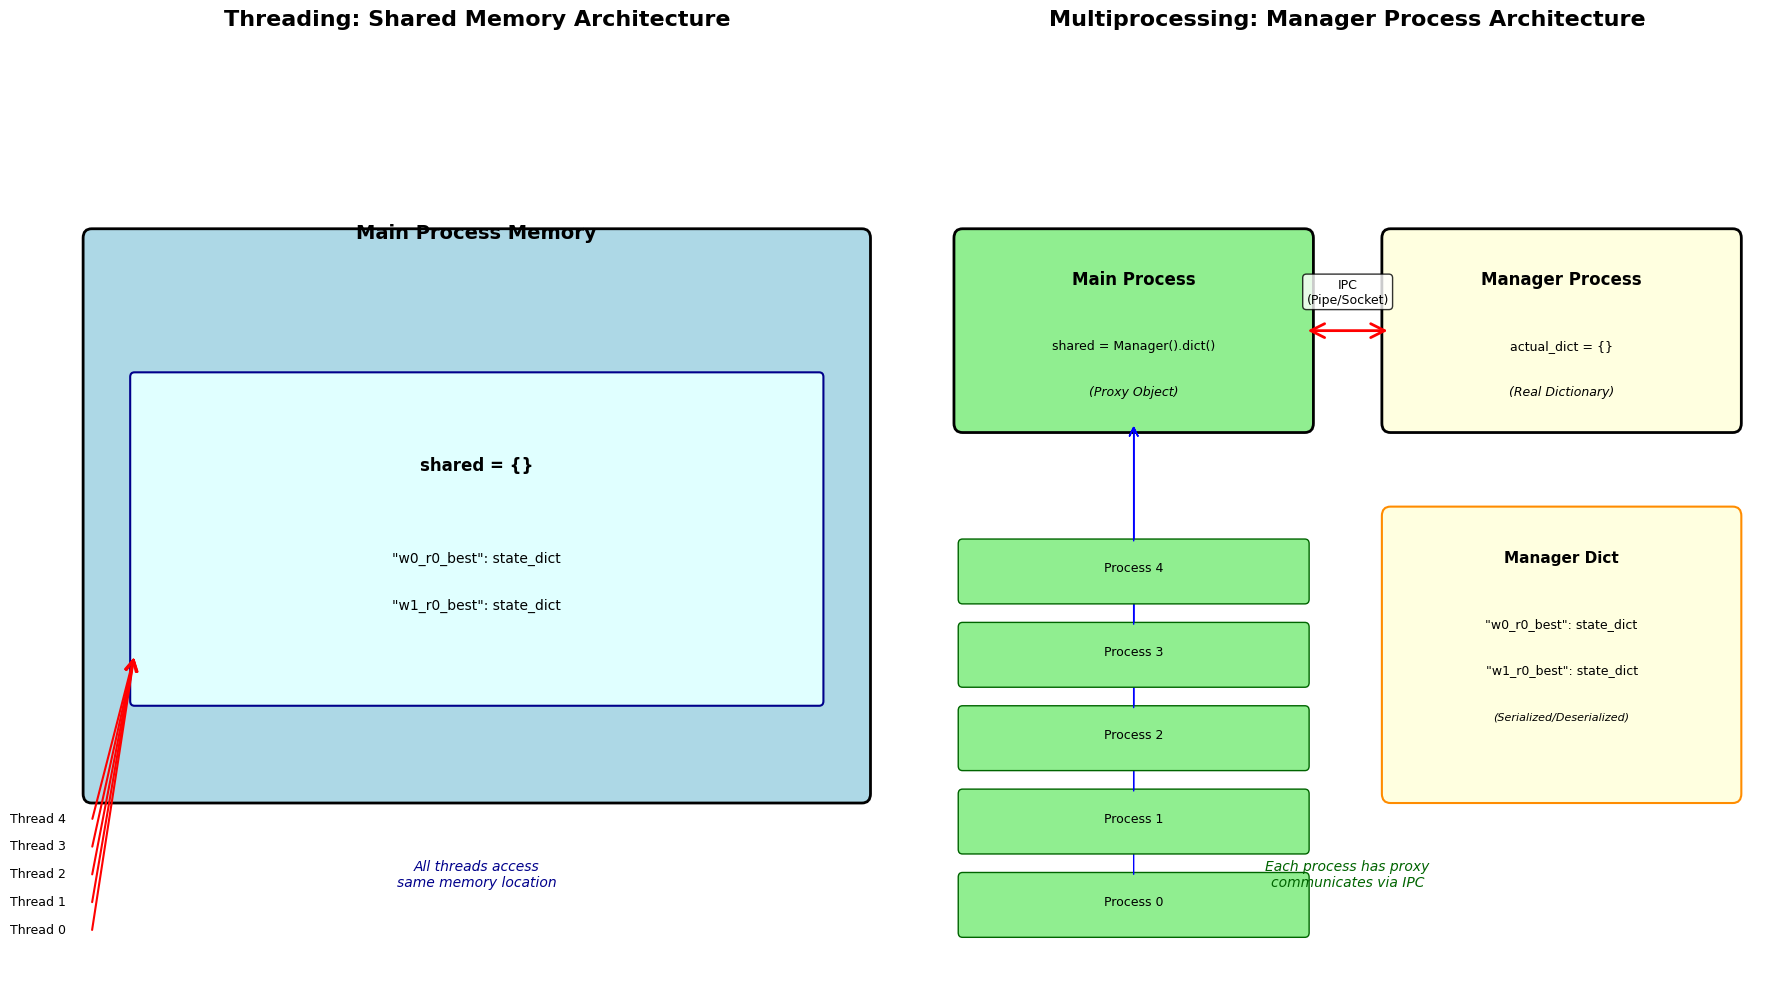


KEY DIFFERENCES IN MEMORY LAYOUT

THREADING:
  • Single memory space (all threads share)
  • Direct pointer access (zero-copy)
  • Fast read/write (memory operations)
  • But: GIL prevents parallel execution

MULTIPROCESSING:
  • Separate memory spaces (each process isolated)
  • Proxy objects communicate via IPC
  • Serialization required (pickle)
  • Slower per-operation, but true parallelism



In [10]:
# Visual representation of memory layouts
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle, FancyBboxPatch, FancyArrowPatch
import matplotlib.patches as mpatches

fig, axes = plt.subplots(1, 2, figsize=(18, 10))

# Threading Memory Layout
ax1 = axes[0]
ax1.set_xlim(0, 10)
ax1.set_ylim(0, 10)
ax1.axis('off')
ax1.set_title('Threading: Shared Memory Architecture', fontsize=16, fontweight='bold', pad=20)

# Main process memory
main_mem = FancyBboxPatch((0.5, 2), 9, 6, 
                          boxstyle="round,pad=0.1", 
                          edgecolor='black', facecolor='lightblue', linewidth=2)
ax1.add_patch(main_mem)
ax1.text(5, 8, 'Main Process Memory', ha='center', fontsize=14, fontweight='bold')

# Shared dict
shared_dict = FancyBboxPatch((1, 3), 8, 3.5, 
                             boxstyle="round,pad=0.05", 
                             edgecolor='darkblue', facecolor='lightcyan', linewidth=1.5)
ax1.add_patch(shared_dict)
ax1.text(5, 5.5, 'shared = {}', ha='center', fontsize=12, fontweight='bold')
ax1.text(5, 4.5, '"w0_r0_best": state_dict', ha='center', fontsize=10)
ax1.text(5, 4, '"w1_r0_best": state_dict', ha='center', fontsize=10)

# Threads
for i in range(5):
    y_pos = 0.5 + i * 0.3
    ax1.text(0.2, y_pos, f'Thread {i}', fontsize=9, ha='right')
    arrow = FancyArrowPatch((0.5, y_pos), (1, 3.5), 
                           arrowstyle='->', mutation_scale=20, 
                           color='red', linewidth=1.5)
    ax1.add_patch(arrow)

ax1.text(5, 1, 'All threads access\nsame memory location', 
        ha='center', fontsize=10, style='italic', color='darkblue')

# Multiprocessing Memory Layout
ax2 = axes[1]
ax2.set_xlim(0, 10)
ax2.set_ylim(0, 10)
ax2.axis('off')
ax2.set_title('Multiprocessing: Manager Process Architecture', fontsize=16, fontweight='bold', pad=20)

# Main process
main_proc = FancyBboxPatch((0.5, 6), 4, 2, 
                          boxstyle="round,pad=0.1", 
                          edgecolor='black', facecolor='lightgreen', linewidth=2)
ax2.add_patch(main_proc)
ax2.text(2.5, 7.5, 'Main Process', ha='center', fontsize=12, fontweight='bold')
ax2.text(2.5, 6.8, 'shared = Manager().dict()', ha='center', fontsize=9)
ax2.text(2.5, 6.3, '(Proxy Object)', ha='center', fontsize=9, style='italic')

# Manager process
manager_proc = FancyBboxPatch((5.5, 6), 4, 2, 
                             boxstyle="round,pad=0.1", 
                             edgecolor='black', facecolor='lightyellow', linewidth=2)
ax2.add_patch(manager_proc)
ax2.text(7.5, 7.5, 'Manager Process', ha='center', fontsize=12, fontweight='bold')
ax2.text(7.5, 6.8, 'actual_dict = {}', ha='center', fontsize=9)
ax2.text(7.5, 6.3, '(Real Dictionary)', ha='center', fontsize=9, style='italic')

# IPC connection
arrow1 = FancyArrowPatch((4.5, 7), (5.5, 7), 
                        arrowstyle='<->', mutation_scale=25, 
                        color='red', linewidth=2)
ax2.add_patch(arrow1)
ax2.text(5, 7.3, 'IPC\n(Pipe/Socket)', ha='center', fontsize=9, 
         bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

# Worker processes
for i in range(5):
    y_pos = 0.5 + i * 0.9
    worker = FancyBboxPatch((0.5, y_pos), 4, 0.6, 
                           boxstyle="round,pad=0.05", 
                           edgecolor='darkgreen', facecolor='lightgreen', linewidth=1)
    ax2.add_patch(worker)
    ax2.text(2.5, y_pos + 0.3, f'Process {i}', ha='center', fontsize=9)
    
    # Arrow to main process
    arrow = FancyArrowPatch((2.5, y_pos + 0.6), (2.5, 6), 
                           arrowstyle='->', mutation_scale=15, 
                           color='blue', linewidth=1)
    ax2.add_patch(arrow)

# Manager dict
manager_dict = FancyBboxPatch((5.5, 2), 4, 3, 
                             boxstyle="round,pad=0.1", 
                             edgecolor='darkorange', facecolor='lightyellow', linewidth=1.5)
ax2.add_patch(manager_dict)
ax2.text(7.5, 4.5, 'Manager Dict', ha='center', fontsize=11, fontweight='bold')
ax2.text(7.5, 3.8, '"w0_r0_best": state_dict', ha='center', fontsize=9)
ax2.text(7.5, 3.3, '"w1_r0_best": state_dict', ha='center', fontsize=9)
ax2.text(7.5, 2.8, '(Serialized/Deserialized)', ha='center', fontsize=8, style='italic')

ax2.text(5, 1, 'Each process has proxy\ncommunicates via IPC', 
        ha='center', fontsize=10, style='italic', color='darkgreen')

plt.tight_layout()
plt.show()

print("\n" + "=" * 70)
print("KEY DIFFERENCES IN MEMORY LAYOUT")
print("=" * 70)
print("""
THREADING:
  • Single memory space (all threads share)
  • Direct pointer access (zero-copy)
  • Fast read/write (memory operations)
  • But: GIL prevents parallel execution

MULTIPROCESSING:
  • Separate memory spaces (each process isolated)
  • Proxy objects communicate via IPC
  • Serialization required (pickle)
  • Slower per-operation, but true parallelism
""")
print("=" * 70)


## 11. Summary: How Threads and Processes Work in Your Code

### Quick Reference Points


In [ ]:
print("=" * 70)
print("HOW THREADS WORK IN ddp_thread.py")
print("=" * 70)
print("""
1. INITIALIZATION:
   • shared = {}  (regular Python dict in main process)
   • shared_lock = threading.Lock()  (for synchronization)
   • All threads share SAME memory address

2. THREAD CREATION:
   • threading.Thread(target=worker_proc, args=(...))
   • Creates N worker threads + 1 aggregator thread
   • All in same process, same memory space

3. WRITE OPERATION:
   with shared_lock:
       shared["key"] = value
   → Direct memory write (fast, ~0.001ms)
   → Same object in memory

4. READ OPERATION:
   with shared_lock:
       value = shared["key"]
   → Direct memory read (fast, ~0.001ms)
   → Gets reference to same object

5. EXECUTION:
   • GIL prevents parallel execution
   • Threads take turns (sequential)
   • Training runs sequentially, not parallel
   • Fast communication, but no speedup
""")

print("\n" + "=" * 70)
print("HOW PROCESSES WORK IN ddp.py")
print("=" * 70)
print("""
1. INITIALIZATION:
   • shared = Manager().dict()  (proxy object)
   • Manager() spawns separate MANAGER PROCESS
   • Each worker process has separate memory

2. PROCESS CREATION:
   • Process(target=worker_proc, args=(...))
   • Creates N worker processes
   • Each process = separate Python interpreter
   • Aggregator runs in main process

3. WRITE OPERATION:
   shared["key"] = value
   → Proxy intercepts
   → Serialize (pickle) → IPC → Manager
   → Manager deserializes → stores
   → Slower (~10-50ms), but no lock needed

4. READ OPERATION:
   value = shared["key"]
   → Proxy requests from Manager
   → Manager serializes → IPC → Worker
   → Worker deserializes → gets NEW COPY
   → Slower (~10-50ms), creates copy

5. EXECUTION:
   • True parallel execution (no GIL)
   • Processes run simultaneously
   • Training runs in parallel
   • Slower communication, but huge speedup
""")

print("\n" + "=" * 70)
print("CODE-SPECIFIC DIFFERENCES")
print("=" * 70)
print("""
THREADING (ddp_thread.py):
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
Line 319:  shared = {}  # Regular dict
Line 322:  shared_lock = threading.Lock()  # Explicit lock
Line 334:  threading.Thread(...)  # Create threads
Line 141:  with shared_lock: shared["key"] = value  # Locked write
Line 151:  with shared_lock: value = shared.get("key")  # Locked read

MULTIPROCESSING (ddp.py):
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
Line 236:  shared = Manager().dict()  # Proxy object
Line 244:  Process(...)  # Create processes
Line 111:  shared["key"] = value  # No lock, proxy handles it
Line 120:  value = shared.get("key")  # No lock, proxy handles it
Line 254:  set_start_method("spawn")  # Windows-compatible

KEY DIFFERENCE:
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
Threading:   Explicit locks required, direct memory access
Multiprocessing: No locks needed, serialized IPC communication
""")
print("=" * 70)
